# Implementation Notes

The internals of ChebPy have been designed to resemble the design structure of MATLAB Chebfun. The Chebfun v5 class diagram thus provides a useful map for understanding how the various pieces of ChebPy fit together (diagram courtesy of the Chebfun team, available [here](https://github.com/chebfun/chebfun/wiki/Class-diagram)):

![](./chebfun-v5-class-diag.png)


At this stage, only a relatively small subset of MATLAB Chebfun has been implemented in ChebPy. In the class diagram above, this consists of all the classes traced by the path going up from from `Chebtech2` (green box in the bottom right), to `Chebfun` (blue box near the top-left). More explicitly, the following classes currently exist in ChebPy:

- `Chebfun` ([core/chebfun.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/chebfun.py))
- `Fun` ([core/fun.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/fun.py))
- `Classicfun` ([core/classicfun.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/classicfun.py))
- `Bndfun` ([core/bndfun.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/bndfun.py))
- `Onefun` ([core/onefun.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/onefun.py))
- `Smoothfun` ([core/smoothfun.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/smoothfun.py))
- `Chebtech` ([core/chebtech.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/chebtech.py))
- `Chebtech2` ([core/chebtech.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/chebtech.py))

ChebPy additionally provides the following classes which do not appear in their present form in MATLAB Chebfun:

- `Interval` ([core/utilities.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/utilities.py))
- `Domain` ([core/utilities.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/utilities.py))

ChebPy allows the user to override some default preferences, similar to what is available through `chebfunpref` in `Chebfun` (bottom right). Not all options are the same, and chebpy allows additional customisation not found in `Chebfun`.

- `UserPrefs` ([core/settings.py](https://github.com/chebpy/chebpy/blob/master/chebpy/core/settings.py))

The general rule is that each ChebPy class lives in its own python file.

One can explore the organisation of the library in practice as follows. We describe the three core components with reference to the colours in the above class diagram.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Chebfun (blue)

We'll start by creating an identity chebfun on an arbitrary non-unit interval:

In [2]:
from chebpy import chebfun

x = chebfun('x', [-2, 3])
x

chebfun column (1 smooth piece)
       interval       length     endpoint values
[      -2,       3]        2        -2        3
vertical scale =   3

This variable is an object of class `Chebfun`:

In [3]:
type(x)

chebpy.core.chebfun.Chebfun

### Fun (yellow)

Conceptually, `Chebfun` objects are defined as a collection (numpy array) of Fun objects. One can access these via the `.funs` attribute, and in this example, since our function is globally smooth, our chebfun is composed of single Fun:

In [4]:
x.funs

array([Bndfun([-2.0, 3.0], 2)], dtype=object)

Fun is an abstract class, so we don't actually see Fun objects per-se, but rather objects further down the inheritance tree. Specifically, we see objects of type `BndFun`, denoting a function defined on a bounded interval.

Here's a piecewise smooth function created by inducing a discontinuity via use of the maximum operator.

In [5]:
f = np.sin(x).maximum(-np.sin(x))
f

chebfun column (2 smooth pieces)
       interval       length     endpoint values
[      -2,-2.2e-16]       20      0.91  2.8e-17
[-2.2e-16,       3]       20  -1.1e-16     0.14
vertical scale =   1    total length = 40

Here the representation consists of two `Fun` objects:

In [6]:
f.funs

array([Bndfun([-2.0, -2.220446049250313e-16], 20),
       Bndfun([-2.220446049250313e-16, 3.0], 20)], dtype=object)

The core `Chebfun` class constructor accepts iterable collections of `Fun` objects, and the above chebfun can be recreated as follows:

In [7]:
from chebpy.core.chebfun import Chebfun
Chebfun(f.funs)

chebfun column (2 smooth pieces)
       interval       length     endpoint values
[      -2,-2.2e-16]       20      0.91  2.8e-17
[-2.2e-16,       3]       20  -1.1e-16     0.14
vertical scale =   1    total length = 40

The Fun objects defining a chebfun must provide a non-overlapping and complete partition of the global approximation interval. ChebPy-specific exceptions will be raised if the user/developer does not properly account for this.

To see this, let's break the second Fun into two sub-pieces (using `fun.restrict`) and attempt various reconstruction permutations.

In [8]:
f.breakpoints

array([-2.00000000e+00, -2.22044605e-16,  3.00000000e+00])

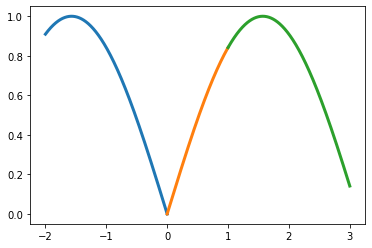

In [9]:
from chebpy.core.utilities import Interval

_, a, c = f.breakpoints
b = 1
fun0 = f.funs[0]
fun1 = f.funs[1].restrict(Interval(a,b))
fun2 = f.funs[1].restrict(Interval(b,c))
fun0.plot(linewidth=3); fun1.plot(linewidth=3); fun2.plot(linewidth=3);
plt.show()

So, the following works:

In [10]:
Chebfun([fun0, fun1, fun2])

chebfun column (3 smooth pieces)
       interval       length     endpoint values
[      -2,-2.2e-16]       20      0.91  2.8e-17
[-2.2e-16,       1]       20  -2.3e-16     0.84
[       1,       3]       20      0.84     0.14
vertical scale =   1    total length = 60

However, the following will raise an exception:

```
>> Chebfun([fun0, fun2])
IntervalGap: The supplied Interval objects do not form a complete partition of the approximation interval
```

As will:

```
>> Chebfun([fun0, f.funs[1], fun1])
IntervalOverlap: The supplied Interval objects overlap
```

### Onefun (green)

A Fun object is defined by the composition of `Onefun` object and an Interval object. A `Onefun` object in ChebPy, as with MATLAB Chebfun, define a set of core approximation behaviour on the unit interval [-1,1]. The computational mechanics of mapping these operations to arbitrary intervals [a,b] is managed, in part, by the a corresponding Interval object.

To illustrate, let's take the first component `Fun` from earlier (which was specifically a `Bndfun`):

In [11]:
f.funs[0]

Bndfun([-2.0, -2.220446049250313e-16], 20)

The Onefun and Interval object components are accessed as follows:

In [12]:
f.funs[0].onefun, f.funs[0].interval

(<Chebtech2{20}>, Interval([-2.00000000e+00, -2.22044605e-16]))

`Onefun` is an abstract class, so what we actually see instantiated is an object of type `Chebtech2`. To see that the `Onefun` object is what is claims to be (a representation defined on the unit-interval), we can plot it (users will rarely do this in practice, but this can nevertheless be a useful feature for developers):

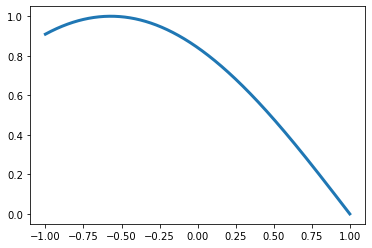

In [13]:
f.funs[0].onefun.plot(linewidth=3)
plt.show()

So while the `Onefun` attribute determines approximation behaviour, the interval attribute manages the mapping to and from the approximation interval to [-1,1]. So for instance, one can evaluate the interval object at some set of points in [-1,1] and obtain these values mapped to [a,b]:

In [14]:
f.funs[0].interval(np.linspace(-1,1,11))

array([-2.00000000e+00, -1.80000000e+00, -1.60000000e+00, -1.40000000e+00,
       -1.20000000e+00, -1.00000000e+00, -8.00000000e-01, -6.00000000e-01,
       -4.00000000e-01, -2.00000000e-01, -2.22044605e-16])

## User preferences (`UserPrefs`)

The user may want to specify different tolerances, for example if speed is important or the function under consideration is particularly difficult. It is also possible to change default behaviour like plotting.

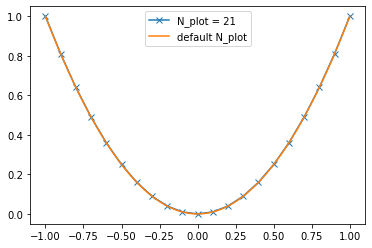

In [15]:
import chebpy  # import entire module to access lower-level parts

chebpy.core.settings.userPrefs.eps = 1e-10  # lower the tolerance in chebpy
cheb = chebpy.chebfun(lambda x: x**2)
chebpy.core.settings.userPrefs.N_plot = 21  # use fewer points for plotting
cheb.plot(marker='x', label='N_plot = 21')
chebpy.core.settings.userPrefs.reset('N_plot')  # restore default
cheb.plot(label='default N_plot')
plt.legend()
plt.show()